In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 [==============================] - 5s 87ms/step - loss: 0.0558 - val_loss: 0.0425
Epoch 2/100
18/18 [==============================] - 1s 53ms/step - loss: 0.0094 - val_loss: 0.0071
Epoch 3/100
18/18 [==============================] - 1s 55ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 4/100
18/18 [==============================] - 2s 85ms/step - loss: 0.0012 - val_loss: 8.6347e-04
Epoch 5/100
18/18 [==============================] - 1s 53ms/step - loss: 5.1368e-04 - val_loss: 1.0027e-04
Epoch 6/100
18/18 [==============================] - 1s 53ms/step - loss: 4.2467e-04 - val_loss: 7.4129e-05
Epoch 7/100
18/18 [==============================] - 1s 57ms/step - loss: 4.1585e-04 - val_loss: 9.9835e-05
Epoch 8/100
18/18 [==============================] - 1s 52ms/step - loss: 3.9928e-04 - val_loss: 9.8915e-05
Epoch 9/100
18/18 [==============================] - 1s 52ms/step - loss: 3.8020e-04 - val_loss: 9.1330e-05
Epoch 10/100
18/18 [==============================] - 1s

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

7/7 [==============================] - 0s 11ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 16585.15113046259


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99953049454226
Testing MAE: 16450.574877847517


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.08241250365972519], [0.08272795379161835], [0.08291708678007126], [0.08304145187139511], [0.08312366902828217], [0.08317509293556213], [0.08320283144712448], [0.08321183919906616], [0.08320575207471848], [0.08318726718425751], [0.08315852284431458], [0.08312111347913742], [0.08307642489671707], [0.08302552253007889], [0.08296927064657211], [0.08290834724903107], [0.08284338563680649], [0.08277486264705658], [0.08270317316055298], [0.08262868225574493], [0.08255164325237274], [0.08247233927249908], [0.08239090442657471], [0.08230756968259811], [0.08222241699695587], [0.0821356251835823], [0.08204720169305801], [0.08195727318525314], [0.08186592161655426], [0.08177317678928375], [0.08167906850576401], [0.0815836563706398], [0.08148694783449173], [0.08138896524906158], [0.08128972351551056], [0.08118924498558044], [0.08108751475811005], [0.08098457753658295], [0.08088039606809616], [0.08077498525381088], [0.08066831529140472], [0.08056040108203888], [0.08045124262571335], [0.080340847

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[17017.38515052],
       [17043.28865355],
       [17058.81949803],
       [17069.03186187],
       [17075.78320593],
       [17080.0059315 ],
       [17082.28370711],
       [17083.02338767],
       [17082.52353737],
       [17081.0056321 ],
       [17078.64526188],
       [17075.57335445],
       [17071.90370682],
       [17067.72380808],
       [17063.10462841],
       [17058.1018427 ],
       [17052.76745495],
       [17047.14062113],
       [17041.25376725],
       [17035.13687211],
       [17028.81073731],
       [17022.2986117 ],
       [17015.61150789],
       [17008.76839206],
       [17001.77599412],
       [16994.64899758],
       [16987.38801423],
       [16980.00344488],
       [16972.50201946],
       [16964.88618523],
       [16957.15838942],
       [16949.32352653],
       [16941.38220838],
       [16933.33627039],
       [16925.1869362 ],
       [16916.93604124],
       [16908.58236188],
       [16900.12956899],
       [16891.57460353],
       [16882.9186891 ],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[-101:])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(311,)


(311, 1)

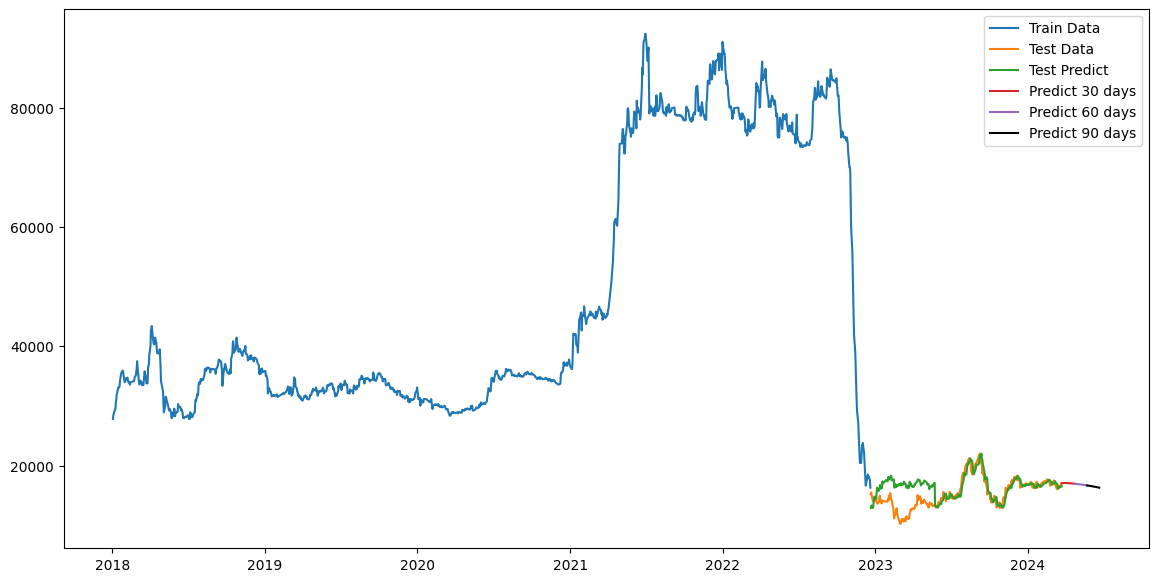

In [19]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()